# Predict severity using construct-text similarity on suicide risk lexicon




In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import sys
import os
# TODO: !pip install construct-tracker

sys.path.append('./../construct-tracker/src/')
sys.path.append('./../construct-tracker/src/construct_tracker/')

from construct_tracker import lexicon
# from importlib import reload
# reload(lexicon)



In [2]:
srl = lexicon.load_lexicon(name = 'srl_v1-0')
srl_prototypes = lexicon.load_lexicon(name = 'srl_prototypes_v1-0')

In [9]:
location = 'local' 

if location == 'colab':
  from google.colab import drive
  project_name = 'concept_tracker'
  drive.mount('/content/drive')
  input_dir = f'/content/drive/MyDrive/datum/{project_name}/data/ctl/'
  output_dir = f'/content/drive/MyDrive/datum/{project_name}/data/output/lexicon_paper/'
elif location == 'openmind':
  input_dir = '/nese/mit/group/sig/projects/dlow/ctl/'
  output_dir = '/home/dlow/datum/lexicon/data/output/mpnet/'
elif location =='local':
  input_dir = './data/input/ctl/'
  output_features_dir = './data/input/ctl/'
  output_ml_dir = './data/output/ml_performance/cts/'

os.makedirs(output_features_dir, exist_ok=True)
os.makedirs(output_ml_dir, exist_ok=True)

In [4]:
balanced_validation_set = False #False: setting it to True had bad performance). It uses 20% the training set as balanced validation, similar to other models that do 5-fold CV


train = pd.read_csv(input_dir+'train10_train_30perc_text_y_balanced_regression.csv', index_col=0)
val = pd.read_csv(input_dir+'train10_val_15perc_text_y_regression.csv', index_col=0)
test = pd.read_csv(input_dir+'train10_test_15perc_text_y_regression.csv', index_col=0)


train = train.dropna()
val = val.dropna()
test = test.dropna()


print(train.shape, val.shape, test.shape)

if balanced_validation_set:
  from sklearn.model_selection import train_test_split
  train, val = train_test_split(train, test_size=0.2, random_state=42)
  print(train.shape, val.shape, test.shape)

(5654, 3) (5353, 3) (5353, 3)


In [5]:
display(train['y'].value_counts())
display(val['y'].value_counts())
display(test['y'].value_counts())

y
1.0    1887
2.0    1884
3.0    1883
Name: count, dtype: int64

y
1.0    4252
2.0     994
3.0     107
Name: count, dtype: int64

y
1.0    4271
2.0     955
3.0     127
Name: count, dtype: int64

### 1. Count tokens using lexicon

In [6]:
# # Now count whether tokens appear in document:
# # About 75 sec for 4160 reddits posts

# load = False

# save_dir = './data/feature_extraction/reddit_27/'

# if load:
# 	counts = pd.read_csv(save_dir+'suicide_risk_lexicon_counts.csv')
# 	counts['subreddit'] = reddit_df_mini['subreddit'].values
# 	with open(save_dir+'suicide_risk_lexicon_matches_construct2doc.json', 'r') as json_file:
# 		matches_construct2doc  = json.load(json_file)

# 	# Can do the same for matches_by_construct, matches_doc2construct

# else:
# 	counts, matches_by_construct, matches_doc2construct, matches_construct2doc  = srl.extract(documents,
# 																						normalize = False,
# 																						save_dir = save_dir
# 																						)
# 	counts['subreddit'] = reddit_df_mini['subreddit'].values
# 	display(counts)
	


In [10]:
# # Interpret counts: visualize matches in context  


# n = 2
# highlight_constructs = ['Lethal means for suicide', 'Passive suicidal ideation', 'Direct self-injury', 'Panic', 'Depressed mood']
# for construct in highlight_constructs:
# 	print(f'Matches for {construct}:')
# 	lexicon.highlight_matches(documents, construct,n, matches_construct2doc, random_seed=42)
# 	print()



### 2. Construct-Text Similarity (CTS)
Find similar tokens to the tokens in the lexicon

In [7]:
from construct_tracker import cts


We'll use the highest prototypes for CTS (3/3 by raters) `srl_prototypes` so that it doesn't find similarity with low prototypical tokens

In [11]:
toy = True

for split in [train, test]:
	if toy:
  		documents = split['text'].sample(20).values
	else:
		documents = split['text'].values
	# 31 sec for 42 reddit posts and 50 constructs. 
	lexicon_dict = srl_prototypes.to_dict()
	features, documents_tokenized, lexicon_dict_final_order, cosine_similarities = cts.measure(
		lexicon_dict,
		documents,
		# You can store and reload embeddings for lexicon tokens
		# stored_embeddings_path = './data/lexicons/suicide_risk_lexicon_v1-0/embeddings_srl-tokens_all-MiniLM-L6-v2.pickle',
		count_if_exact_match = 'sum',
		similarity_threshold = None, 
        save_dir = output_features_dir
		
		)


	# Save


TypeError: measure() got an unexpected keyword argument 'save_dir'

In [21]:
# If below threshold then replace with NaN
threshold = 0.45 # depends on embeddings used

highlight_constructs_max = [n+'_max' for n in highlight_constructs]

features_threshold = features[highlight_constructs_max]
features_threshold[features_threshold <= threshold] = 0
features_threshold['subreddit'] = subreddits


/var/folders/6f/x95fldf13xn_k25tybdzgtqw0000gn/T/ipykernel_40969/4082478602.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_threshold[features_threshold <= threshold] = 0
/var/folders/6f/x95fldf13xn_k25tybdzgtqw0000gn/T/ipykernel_40969/4082478602.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_threshold[features_threshold <= threshold] = 0
/var/folders/6f/x95fldf13xn_k25tybdzgtqw0000gn/T/ipykernel_40969/4082478602.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [22]:
features_threshold

,Lethal means for suicide_max,Passive suicidal ideation_max,Direct self-injury_max,Panic_max,Depressed mood_max,subreddit
0,0.000000,0.000000,0.000000,0.509904,0.000000,suicidewatch
1,0.680776,0.465988,0.000000,0.000000,1.597430,suicidewatch
2,0.520472,0.493905,0.516625,2.228563,0.000000,anxiety
3,0.000000,0.000000,0.000000,0.000000,0.637648,depression
4,0.000000,0.000000,0.000000,0.000000,0.000000,depression
5,0.000000,0.000000,0.000000,0.000000,0.000000,bpd
6,0.000000,0.000000,0.000000,0.000000,0.000000,suicidewatch
7,0.000000,0.527037,0.000000,0.000000,0.467695,suicidewatch
8,0.000000,0.000000,0.000000,0.610785,0.000000,depression
9,0.000000,0.000000,0.000000,0.486648,3.335488,depression


Text(0, 0.5, 'Sum of cosine similarities > 0.45')

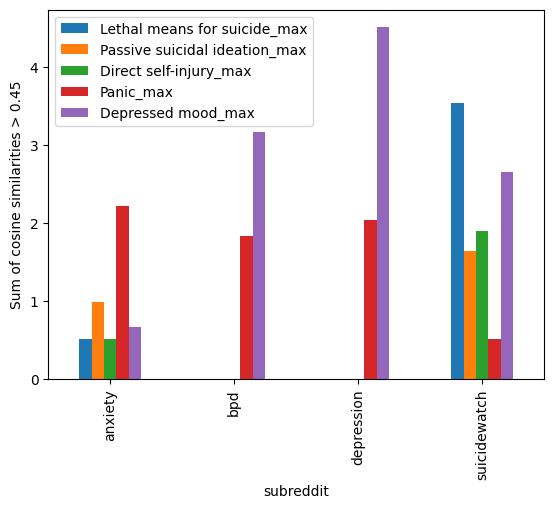

In [24]:
# Bar plot of counts split by subreddit
features_threshold[highlight_constructs_max+['subreddit']].groupby('subreddit').sum().plot.bar()
plt.ylabel(f'Sum of cosine similarities > {threshold}')


In [26]:
features

,document_id,documents,documents_tokenized,Passive suicidal ideation_max,Active suicidal ideation & suicidal planning_max,Lethal means for suicide_max,Direct self-injury_max,Suicide exposure_max,Other suicidal language_max,Hospitalization_max,...,Borderline Personality Disorder_max,Eating disorders_max,Physical health issues & disability_max,Incarceration_max,Poverty & homelessness_max,Gender & sexual identity_max,Discrimination_max,Finances & work stress_max,Barriers to treatment_max,Mental health treatment_max
0,3,Is it life really worth living? I finished col...,"[Is it life really worth living?, I finished c...",0.342068,0.363032,0.356042,0.342099,0.359464,0.361808,0.304708,...,0.357558,0.191411,0.423201,0.196732,0.229507,0.177132,0.283880,1.136634,0.386409,0.430727
1,6,I’m broken and unlovable I spent the first 17 ...,"[I ’m broken, unlovable, I spent the first 17 ...",0.465988,0.680776,0.680776,0.377227,0.338367,0.414275,0.173597,...,0.236894,0.210469,0.349397,0.305260,0.269526,0.251443,0.304289,0.347974,0.381636,0.281913
2,4,Anxiety about my brain My panic attacks come i...,[Anxiety about my brain My panic attacks come ...,0.493905,0.668989,0.520472,0.516625,0.507007,0.443123,0.137774,...,0.230586,0.285810,2.242476,0.235414,0.279124,0.242393,0.251336,0.279124,0.467615,1.208259
3,9,Scared of my own thoughts I was listening to m...,[Scared of my own thoughts I was listening to ...,0.347674,0.384690,0.279352,0.278162,0.409336,0.535517,0.340621,...,0.297117,0.304388,0.381759,0.252667,0.383834,0.385792,0.267281,0.264661,0.460263,0.454348
4,10,I'm not going to kill myself today. Not today.,"[I'm not going to kill myself today., Not today.]",0.293187,1.341518,0.266488,0.266488,0.236186,0.383790,0.253287,...,0.249334,0.244370,0.488096,0.262029,0.286278,0.321696,0.349836,0.350303,0.435144,0.337130
5,11,Really scared to lose my FP. Am I overreacting...,"[Really scared to lose my FP., Am I overreacti...",0.399596,0.354134,0.345777,0.345777,0.309872,0.345661,0.169186,...,4.213831,0.384920,0.324597,0.397207,0.272356,1.321589,0.329901,0.313254,0.403173,0.394934
6,8,Been through this a few times. The time is nea...,"[Been through this a few times., The time is n...",0.293561,0.196077,0.181616,0.171940,0.063814,0.201602,0.133601,...,0.209616,0.162772,0.192501,0.181873,0.282352,0.272277,0.248202,0.257586,0.313266,0.232274
7,7,Trying to pull together Sometimes I feel like ...,"[Trying to pull together, Sometimes I feel lik...",0.527037,0.411099,0.411099,0.400868,0.250736,0.426170,0.175309,...,0.354387,0.293729,0.312047,0.287790,0.310636,0.382455,0.372048,0.364346,0.378333,0.317450
8,2,Couch vs Bed Is it just me or do other people ...,"[Couch vs Bed Is it just me or? \n\n, do other...",0.319615,0.563512,0.244654,0.289401,0.236511,0.325880,0.330769,...,0.297471,0.256870,0.589457,0.272723,0.240220,0.311332,0.310004,0.299499,0.526168,0.459947
9,5,What are some things I can do to be supportive...,[What are some things I can do to be supportiv...,0.418472,0.286675,0.367676,0.275199,0.374292,0.460067,0.227693,...,0.632436,0.354898,0.340465,0.276662,0.411375,0.378128,0.439169,0.337952,0.500486,0.339172


In [36]:
counts

,document_id,document,Passive suicidal ideation,Active suicidal ideation & suicidal planning,Lethal means for suicide,Direct self-injury,Suicide exposure,Other suicidal language,Hospitalization,Loneliness & isolation,...,Physical health issues & disability,Incarceration,Poverty & homelessness,Gender & sexual identity,Discrimination,Finances & work stress,Barriers to treatment,Mental health treatment,word_count,subreddit
0,0,Is it life really worth living? I finished col...,1,1,0,0,0,2,0,2,...,0,0,0,0,0,2,0,0,200,suicidewatch
1,1,I’m broken and unlovable I spent the first 17 ...,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,142,suicidewatch
2,2,Anxiety about my brain My panic attacks come i...,0,0,0,0,0,1,0,0,...,2,0,0,0,0,0,0,1,73,anxiety
3,3,Scared of my own thoughts I was listening to m...,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,42,depression
4,4,I'm not going to kill myself today. Not today.,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,depression
5,5,Really scared to lose my FP. Am I overreacting...,0,0,0,0,0,0,0,3,...,0,0,0,1,0,1,0,0,400,bpd
6,6,Been through this a few times. The time is nea...,0,0,2,0,0,1,0,0,...,1,0,0,0,0,0,0,0,108,suicidewatch
7,7,Trying to pull together Sometimes I feel like ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,75,suicidewatch
8,8,Couch vs Bed Is it just me or do other people ...,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,68,depression
9,9,What are some things I can do to be supportive...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,86,depression


,document_id,document,Passive suicidal ideation,Active suicidal ideation & suicidal planning,Lethal means for suicide,Direct self-injury,Suicide exposure,Other suicidal language,Hospitalization,Loneliness & isolation,...,Physical health issues & disability,Incarceration,Poverty & homelessness,Gender & sexual identity,Discrimination,Finances & work stress,Barriers to treatment,Mental health treatment,word_count,subreddit
0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,suicidewatch
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,suicidewatch
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,anxiety
3,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,depression
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,depression
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bpd
6,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,suicidewatch
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,suicidewatch
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,depression
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,depression


In [40]:
result

,document_id,document,Passive suicidal ideation,Active suicidal ideation & suicidal planning,Lethal means for suicide,Direct self-injury,Suicide exposure,Other suicidal language,Hospitalization,Loneliness & isolation,...,Physical health issues & disability,Incarceration,Poverty & homelessness,Gender & sexual identity,Discrimination,Finances & work stress,Barriers to treatment,Mental health treatment,word_count,subreddit
0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,suicidewatch
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,suicidewatch
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,anxiety
3,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,depression
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,depression
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bpd
6,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,suicidewatch
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,suicidewatch
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,depression
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,depression


In [42]:
highlight_constructs

['Lethal means for suicide',
 'Passive suicidal ideation',
 'Direct self-injury',
 'Panic',
 'Depressed mood']

Text(0, 0.5, 'Sum of cosine similarities')

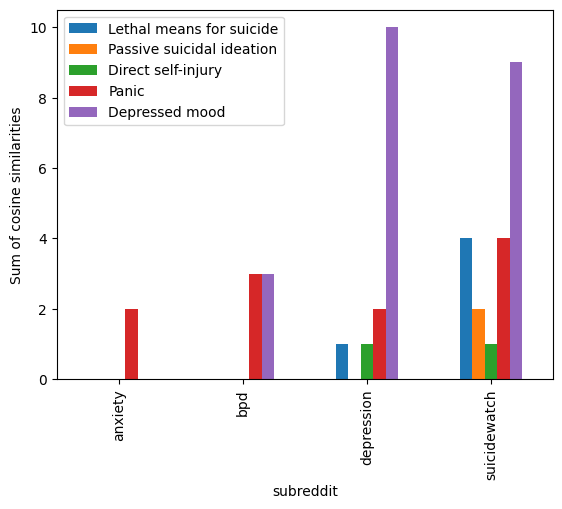

In [43]:
# Creating the new dataframe based on the conditions
result = counts[highlight_constructs].where(counts[highlight_constructs] >= 1, features_threshold)
result['subreddit']=subreddits


# Bar plot of counts split by subreddit
result[highlight_constructs+['subreddit']].groupby('subreddit').sum().plot.bar()
plt.ylabel(f'Sum of cosine similarities')


/var/folders/6f/x95fldf13xn_k25tybdzgtqw0000gn/T/ipykernel_40969/1661374701.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_threshold[features_threshold <= threshold] = np.nan
/var/folders/6f/x95fldf13xn_k25tybdzgtqw0000gn/T/ipykernel_40969/1661374701.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_threshold[features_threshold <= threshold] = np.nan


Text(0, 0.5, 'Sum of cosine similarities > 0.45')

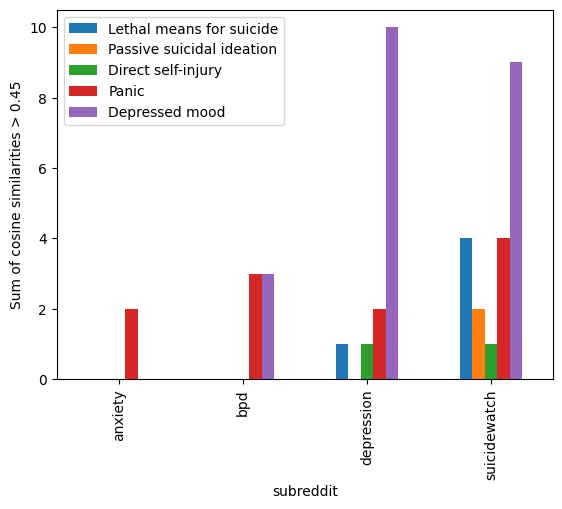

In [45]:
# If below threshold then replace with NaN
threshold = 0.45 # depends on embeddings used

features_threshold = result[highlight_constructs]
features_threshold[features_threshold <= threshold] = np.nan
features_threshold['subreddit'] = subreddits

features_threshold[highlight_constructs+['subreddit']].groupby('subreddit').sum().plot.bar()
plt.ylabel(f'Sum of cosine similarities > {threshold}')

/var/folders/6f/x95fldf13xn_k25tybdzgtqw0000gn/T/ipykernel_59795/3969709421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_threshold[features_threshold <= threshold] = np.nan
/var/folders/6f/x95fldf13xn_k25tybdzgtqw0000gn/T/ipykernel_59795/3969709421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_threshold[features_threshold <= threshold] = np.nan
/var/folders/6f/x95fldf13xn_k25tybdzgtqw0000gn/T/ipykernel_59795/3969709421.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

Text(0, 0.5, 'Sum of cosine similarities > 0.7')

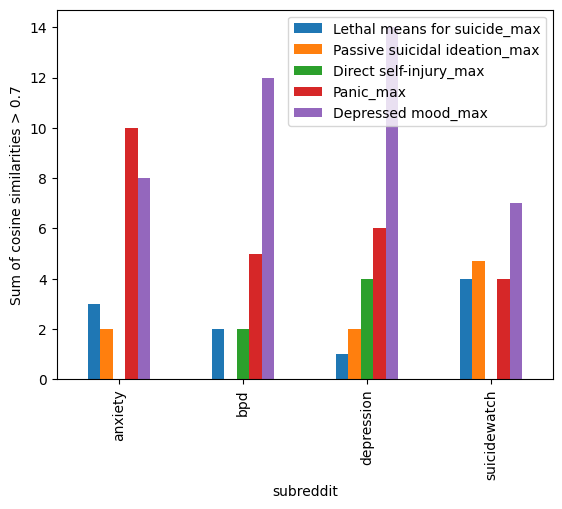

In [ ]:
# If below threshold then replace with NaN
threshold = 0.70 # depends on embeddings used
features_threshold = result[highlight_constructs_max]
features_threshold[features_threshold <= threshold] = np.nan
features_threshold['subreddit'] = subreddits

features_threshold[highlight_constructs_max+['subreddit']].groupby('subreddit').sum().plot.bar()
plt.ylabel(f'Sum of cosine similarities > {threshold}')

In [47]:
# TODO: tokenization messing up space, which doesnt allow highlithing matches in context
# TODO: highlight exact match if possible: replace values in cosine_similarities
# Interpret scores
doc_id = 7

# Interpret counts: visualize matches in context  

highlight_constructs = ['Lethal means for suicide', 'Passive suicidal ideation', 'Direct self-injury', 'Panic', 'Depressed mood']
for construct in highlight_constructs:
	print(f'Matches for {construct}:')
	
	most_similar_lexicon_token, most_similar_document_token, highest_similarity = cts.get_highest_similarity_phrase(doc_id, construct, documents, documents_tokenized, cosine_similarities, lexicon_dict_final_order)
	print()



Matches for Lethal means for suicide:
The construct 'Lethal means for suicide' through its token 'hanging myself' had the highest cosine similarity (0.41) with the following document token:
'Trying to pull together'



Matches for Passive suicidal ideation:
The construct 'Passive suicidal ideation' through its token 'wish I would not wake up' had the highest cosine similarity (0.53) with the following document token:
'but I ca n’t shake the feeling that no one would notice if I just did n’t wake up.'



Matches for Direct self-injury:
The construct 'Direct self-injury' through its token 'burn myself' had the highest cosine similarity (0.4) with the following document token:
'Ca n’t bring myself to tell anyone I still feel this way'



Matches for Panic:
The construct 'Panic' through its token 'panic' had the highest cosine similarity (0.32) with the following document token:
'cared'



Matches for Depressed mood:
The construct 'Depressed mood' through its token 'I feel sad all the time' had the highest cosine similarity (0.47) with the following document token:
'Sometimes I feel like I do n’t exist.'
